length of Data after cleaning the database: 35827


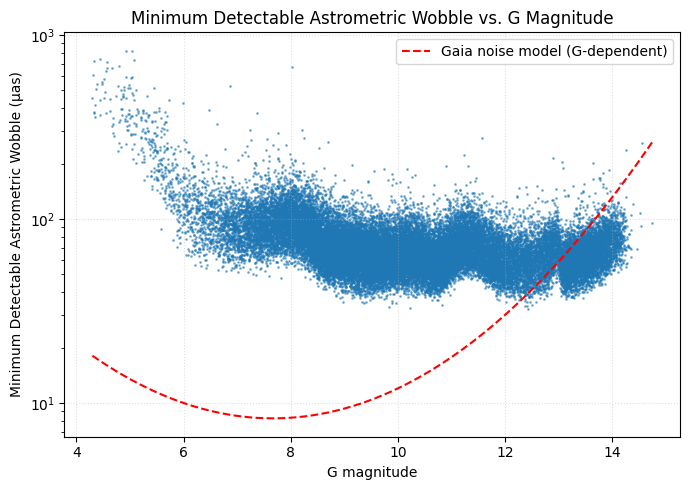

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')
#creating a new dataframe with only the required columns
# Note: Ensure 'data.csv' contains the necessary columns as per the context. 
df = df[['mass', 'parallax', 'pmra_error', 'pmdec_error', 'ruwe', 'teff_gspphot', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag']]

#checking if required columns are present. nan are dropped.
required_columns = ['mass','pmra_error', 'pmdec_error', 'parallax', 'ruwe', 'teff_gspphot', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
    
# Dropping rows with NaN values in required columns
df = df.dropna(subset=required_columns)
df = df[df['ruwe'] < 1.4]

print ('length of Data after cleaning the database:', len(df))

df['alpha_min'] = 3 * np.sqrt(df['pmra_error']**2 + df['pmdec_error']**2) * 1e3
df['distance_pc'] = 1000 / df['parallax']


# Sozzetti et al. (2014), A&A 572, A36 discuss detection limits for Gaia astrometry based on error ellipses and SNR.

# Perryman et al. (2014), “Astrometric Exoplanet Detection with Gaia” explains sensitivity roughly scaling with proper motion errors.

# (Lindegren et al. 2021)
def gaia_noise_floor(gmag):
    """Empirical fit to Gaia EDR3 astrometric noise (μas)"""
    return 10**(
        0.5 * (gmag - 16.0)  # Linear term (bright stars)
        + 0.03 * (gmag - 16.0)**2  # Quadratic term (faint stars)
    ) * 1e3  # Convert to μas
    
# Gaia astrometric performance papers:
# Lindegren et al. (2018), “Gaia Data Release 2 — The astrometric solution,” A&A 616, A2
# (https://doi.org/10.1051/0004-6361/201832727)
# — For astrometric errors vs. magnitude, and noise floor behavior.

# Astrometric planet detection sensitivity:
# Perryman et al. (2014), “Astrometric Exoplanet Detection with Gaia,”
# (https://arxiv.org/abs/1404.2935)
# — Discusses detection thresholds based on proper motion errors.

# Signal detection thresholds:
# General statistics on 3σ detection thresholds as signal significance criteria.


plt.figure(figsize=(7, 5))
plt.scatter(df['phot_g_mean_mag'], df['alpha_min'], s=1, alpha=0.5)

# Step 6: Plot the Gaia noise model as a red dashed curve
g_vals = np.linspace(df['phot_g_mean_mag'].min(), df['phot_g_mean_mag'].max(), 500)
plt.plot(g_vals, gaia_noise_floor(g_vals), 'r--', label='Gaia noise model (G-dependent)')

# Step 7: Final plot styling
plt.xlabel('G magnitude')
plt.ylabel(r'$\alpha_{\rm min}$ (μas)')
plt.ylabel('Minimum Detectable Astrometric Wobble (μas)')
plt.yscale('log')
plt.title('Minimum Detectable Astrometric Wobble vs. G Magnitude')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.savefig('alpha_min_vs_gmag_modelcurve.pdf')
plt.show()


In [3]:
import numpy as np
import pandas as pd

def find_bprp(bp,rp):
    return bp-rp
    
def classify_spectral_type(bp_rp):
    if bp_rp < -0.25:
        return "O/B"  # Hot stars (O/B types are hard to distinguish without UV data)
    elif bp_rp < 0.25:
        return "A"
    elif bp_rp < 0.60:
        return "F"
    elif bp_rp < 0.90:
        return "G"
    elif bp_rp < 1.40:
        return "K"
    else:
        return "M"  # Cool stars (M dwarfs/giants)

def temp_class(teff):
    if teff > 30000:
        return "O"
    elif teff > 10000:
        return "B"
    elif teff > 7500:
        return "A"
    elif teff > 6000:
        return "F"
    elif teff > 5200:
        return "G"
    elif teff > 3700:
        return "K"
    else:
        return "M"
    
df['bp_rp'] = (df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])
df['spectral_type'] = df['bp_rp'].apply(classify_spectral_type)
df['spectral_type_temp'] = df['teff_gspphot'].apply(temp_class)
df['confirm'] = df['spectral_type'] == df['spectral_type_temp']

print ("total number of stars before confirming the spectral types: ", len(df))

# select only those that confirm true
df = df[df['confirm'] == True]
df.to_csv('data_with_spectral_type.csv', index=False)

#show total number of stars
print(f"Total number of stars with confirmed spectral types : {len(df)}")

#list all the spectral types we have
spectral_types = df['spectral_type'].unique()
print("Spectral types in the dataset:", spectral_types)

#list the number of stars in each spectral type
spectral_counts = df['spectral_type'].value_counts()
print("Number of stars in each spectral type:")
print(spectral_counts)

total number of stars before confirming the spectral types:  35827
Total number of stars with confirmed spectral types : 19726
Spectral types in the dataset: ['K' 'M' 'F' 'G' 'A']
Number of stars in each spectral type:
spectral_type
G    8238
K    8080
M    1702
F    1530
A     176
Name: count, dtype: int64


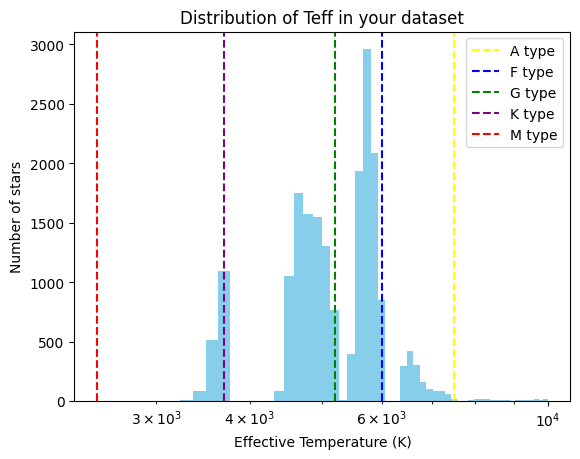

In [4]:
import matplotlib.pyplot as plt

plt.hist(df['teff_gspphot'].dropna(), bins=50, color='skyblue')
#dividing regions based on spectral types
plt.axvline(x=7500, color='yellow', linestyle='--', label='A type')
plt.axvline(x=6000, color='blue', linestyle='--', label='F type') 
plt.axvline(x=5200, color='green', linestyle='--', label='G type')
plt.axvline(x=3700, color='purple', linestyle='--', label='K type')
plt.axvline(x=2500, color='red', linestyle='--', label='M type')
plt.legend()
plt.xscale('log')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Number of stars')
plt.title('Distribution of Teff in your dataset')
plt.savefig('teff.pdf')
plt.show()


In [7]:
planet_classes = {
    'Mercury_like':     {'radius': 0.5,  'mass': 0.055},   # Mercury radius & mass in Earth units
    'Earth_like':       {'radius': 1.0,  'mass': 1.0},     # Earth radius & mass
    'Super_Earth':      {'radius': 1.5,  'mass': 5.0},     # Around 1.25–1.75 R⊕, mass ~5 M⊕
    'Sub_Neptune':      {'radius': 2.8,  'mass': 7.0},     # Typical mini-Neptune size & mass
    'Neptune_like':     {'radius': 3.9,  'mass': 17.1},    # Neptune radius & mass
    'Sub_Saturn':       {'radius': 7.0,  'mass': 60.0},    # Intermediate gas giant (between Neptune and Saturn)
    'Saturn_like':      {'radius': 9.5,  'mass': 95.0},    # Saturn radius & mass
    'Jupiter_like':     {'radius': 11.2, 'mass': 317.8},   # Jupiter radius & mass
    'Super_Jupiter':    {'radius': 13.0, 'mass': 1000.0}   # Larger/more massive gas giants, below brown dwarf limit
}

planet_names = list(planet_classes.keys())

def calculate_min_semi_major_axis(type, alpha_min, distance , mass_star):
  
  ''' units to be used: '''
  # as of now, the alpha_min is in micro arcseconds, distance in parsecs, and mass_star in solar masses
  # the only conversion to be done is for the mass of the planet, which should be in solar masses as well
  #convert solar mass to earth mass
  mass_star = mass_star * 333000  # 1 solar mass = 333,000 Earth masses
  
  for planet, props in planet_classes.items():
    if planet.lower() == type.lower():
      mass_planet = props['mass']
      break
  alpha_arcsec = alpha_min * 1e-6
  return alpha_arcsec * distance * (mass_star / mass_planet)

df['alpha_min_arcsec'] = df['alpha_min'] * 1e-6

data = df.copy()

def calc(what):
  data[what]  = data.apply(lambda row: calculate_min_semi_major_axis(what, row['alpha_min'], row['distance_pc'], row['mass']), axis=1)

for planet in planet_names:
    calc(planet)

data.to_csv('data_with_planet_min_semi_major_axis.csv', index=False)
print ('done. total number of stars with assigned min semi major axis for planets is:', len(data))


done. total number of stars with assigned min semi major axis for planets is: 19726


In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('data_with_planet_min_semi_major_axis.csv')

# =============================================
# 1. Luminosity Calculation (3 Methods)
# =============================================
def calculate_luminosity(row):
    """
    Best-available luminosity calculation using:
    1. Photometry (preferred) → Uses Gaia G mag + BP-RP color
    2. Mass-luminosity relation (fallback)
    """
    # Method 1: Gaia DR3 photometric luminosity (most accurate)
    try:
        # Absolute G magnitude
        M_G = row['phot_g_mean_mag'] - 5 * np.log10(row['distance_pc']) + 5
        
        # Bolometric correction (Torres 2010, validated for Gaia)
        BC_G = 0.0062 * row['bp_rp']**3 - 0.1048 * row['bp_rp']**2 + 0.4951 * row['bp_rp'] - 0.4697
        M_bol = M_G + BC_G
        
        return 10 ** (0.4 * (4.74 - M_bol))  # L/L_sun
    
    except:
        # Method 2: Mass-luminosity relation (fallback)
        return row['mass'] ** 3.5  # L ∝ M^3.5 for main-sequence

df['lum'] = df.apply(calculate_luminosity, axis=1)

# =============================================
# 2. Habitable Zone Calculation (Kopparapu 2014+)
# =============================================
def calculate_habitable_zone(teff, lum):
    """
    Calculates both HZ boundaries with:
    - Kopparapu et al. (2014) polynomials
    - M-dwarf corrections (Kopparapu 2016)
    - Stability safeguards
    """
    # Coefficients (Runaway Greenhouse / Maximum Greenhouse)
    inner_coeffs = [1.107, 1.332, -0.142, -0.102, -0.009]
    outer_coeffs = [0.320, 0.612, -0.043, -0.011, -0.001]
    
    def S_eff(teff, coeffs):
        T_star = teff - 5780  # Offset from solar Teff
        # 4th-order polynomial calculation
        return max(coeffs[0] + 
                 coeffs[1]*1e-4*T_star + 
                 coeffs[2]*1e-8*T_star**2 + 
                 coeffs[3]*1e-12*T_star**3 + 
                 coeffs[4]*1e-16*T_star**4, 0.01)  # Physical floor
    
    # Base calculation
    S_inner = S_eff(teff, inner_coeffs)
    S_outer = S_eff(teff, outer_coeffs)
    
    # M-dwarf correction (Teff < 3700K)
    if teff < 3700:
        S_inner *= 0.9  # Inner edge moves inward
        S_outer *= 1.1  # Outer edge moves outward
    
    return np.sqrt(lum/S_inner), np.sqrt(lum/S_outer)

# Calculate boundaries
df[['HZ_inner_au', 'HZ_outer_au']] = df.apply(
    lambda row: calculate_habitable_zone(row['teff_gspphot'], row['lum']), 
    axis=1, result_type='expand'
)

# =============================================
# 3. Validation & Output
# =============================================
# Remove unphysical cases
df = df[(df['HZ_inner_au'] > 0) & (df['HZ_outer_au'] > df['HZ_inner_au'])]

planet_types = ['Mercury_like', 'Earth_like', 'Super_Earth', 'Sub_Neptune', 'Neptune_like', 'Sub_Saturn', 'Saturn_like', 'Jupiter_like', 'Super_Jupiter']

for planet in planet_types:
    df[f'{planet}_detectable'] = (df[planet] <= df['HZ_outer_au']).astype(int)

# Save results
df.to_csv('hab/habitable_zones_calculated.csv', index=False)
print(f"Successfully calculated HZ for {len(df)} stars")
print(f"Inner HZ range: {df['HZ_inner_au'].min():.2f}-{df['HZ_inner_au'].max():.2f} AU")
print(f"Outer HZ range: {df['HZ_outer_au'].min():.2f}-{df['HZ_outer_au'].max():.2f} AU")

Successfully calculated HZ for 19726 stars
Inner HZ range: 0.10-6.20 AU
Outer HZ range: 0.18-10.53 AU


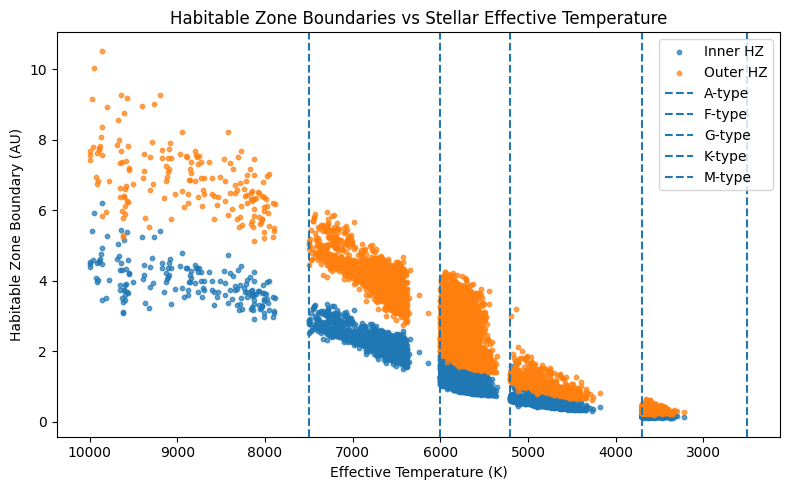

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df['teff_gspphot'], df['HZ_inner_au'], s=10, alpha=0.7, label='Inner HZ')
plt.scatter(df['teff_gspphot'], df['HZ_outer_au'], s=10, alpha=0.7, label='Outer HZ')

# Spectral type boundaries (approximate)
for x, label in zip([7500, 6000, 5200, 3700, 2500], ['A', 'F', 'G', 'K', 'M']):
    plt.axvline(x=x, linestyle='--', label=f'{label}-type')

plt.xlabel('Effective Temperature (K)')
plt.ylabel('Habitable Zone Boundary (AU)')
plt.gca().invert_xaxis()
plt.legend()
plt.title('Habitable Zone Boundaries vs Stellar Effective Temperature')
plt.tight_layout()
plt.savefig('hz_boundaries_vs_teff.pdf')
plt.show()


In [37]:
data = pd.read_csv('hab/habitable_zones_calculated.csv')
spectral_types = data['spectral_type'].unique()

for spectral_type in spectral_types:
    subset = data[data['spectral_type'] == spectral_type]
    subset = subset[['mass', 'parallax', 'alpha_min_arcsec', 'spectral_type', 'distance_pc', 'Mercury_like_detectable', 'Earth_like_detectable', 'Super_Earth_detectable', 'Sub_Neptune_detectable', 'Neptune_like_detectable', 'Sub_Saturn_detectable', 'Saturn_like_detectable', 'Jupiter_like_detectable', 'Super_Jupiter_detectable','HZ_inner_au', 'HZ_outer_au']]

    safe_name = spectral_type.replace(" ", "_").replace("/", "_")
    subset.to_csv(f'{spectral_type}/spectral_type_{safe_name}.csv', index=False)

    print(f"Saved {len(subset)} stars to spectral_type_{safe_name}.csv")

Saved 8080 stars to spectral_type_K.csv
Saved 1702 stars to spectral_type_M.csv
Saved 1530 stars to spectral_type_F.csv
Saved 8238 stars to spectral_type_G.csv
Saved 176 stars to spectral_type_A.csv


In [44]:
import pandas as pd

lst = ['A', 'F', 'G', 'K', 'M']
P = ['Mercury_like_detectable', 'Earth_like_detectable', 'Super_Earth_detectable',
     'Sub_Neptune_detectable', 'Neptune_like_detectable', 'Sub_Saturn_detectable',
     'Saturn_like_detectable', 'Jupiter_like_detectable', 'Super_Jupiter_detectable']

# Dictionary to collect rows
table_data = {}

for star in lst:
    l = pd.read_csv(f'{star}/spectral_type_{star}.csv')
    
    # For each star type, compute a dictionary of planet counts
    counts = {}
    for planet_d in P:
        counts[planet_d] = l[l[planet_d] != 0][planet_d].count()
    
    table_data[star] = counts

# Create a DataFrame from the dictionary and transpose it
df = pd.DataFrame.from_dict(table_data, orient='index')
df.index.name = 'Spectral Type'

# Display the table
print("\n=== Detectable Planets per Star Type ===\n")
print(df.to_string())



=== Detectable Planets per Star Type ===

               Mercury_like_detectable  Earth_like_detectable  Super_Earth_detectable  Sub_Neptune_detectable  Neptune_like_detectable  Sub_Saturn_detectable  Saturn_like_detectable  Jupiter_like_detectable  Super_Jupiter_detectable
Spectral Type                                                                                                                                                                                                                           
A                                    0                      0                       0                       0                        0                      0                       0                        0                        57
F                                    0                      0                       0                       0                        0                      0                       0                        5                      1077
G                        

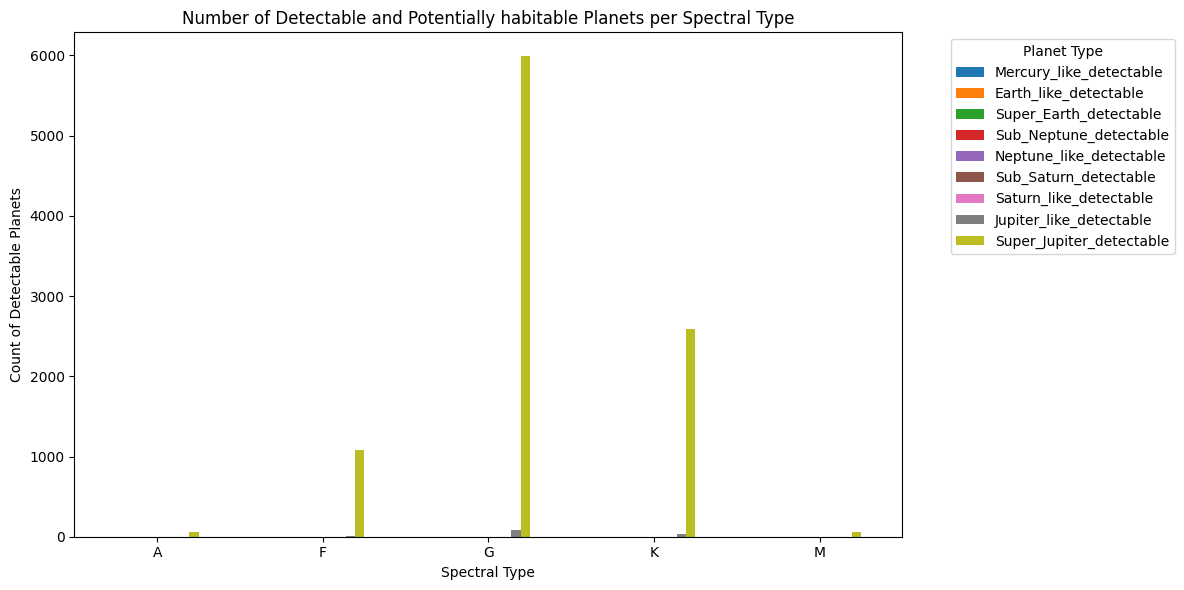

In [47]:
import matplotlib.pyplot as plt

df.plot(kind='bar', figsize=(12,6))
plt.title('Number of Detectable and Potentially habitable Planets per Spectral Type')
plt.xlabel('Spectral Type')
plt.ylabel('Count of Detectable Planets')
plt.xticks(rotation=0)
plt.legend(title='Planet Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
